<h1 align="center"><font size="5">Capstone Project</font></h1>


This notebook will be used for the Coursera Capstone Project. This project is part of the **Applied Data Science Capstone Course** of IBM Data Science Certificate.

# Setup

In [0]:
import sys
sys.version

'3.6.9 (default, Apr 18 2020, 01:56:04) \n[GCC 8.4.0]'

In [0]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
import matplotlib.pyplot as plt

#Visualization Libraries
import seaborn as sns
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#Data Collection
import requests
from bs4 import BeautifulSoup
print('Libraries imported.')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Libraries imported.


In [0]:
#saving path
save_path = "/content/drive/My Drive/Colab Notebooks/Capstone Project"

## Distance Function

In [0]:
address = 'Paris'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Paris are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Paris are 48.8566969, 2.3514616.


In [0]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)


# add markers to the map
label = folium.Popup('Center')
folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='Blue',
        fill=True,
        fill_color='Blue',
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

In [0]:
#create distance functions from center with Haversine formula
import math

def distance(lat1, lon1):

    radius_list = []
    lat2 = latitude
    lon2 = longitude
    radius = 6371 # km

    for lat1, lon1 in zip(lat1, lon1):  
      dlat = math.radians(lat2-lat1)
      dlon = math.radians(lon2-lon1)
      a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
      c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
      d = radius * c

      radius_list.append([(d)])

    #Append the DataFrame

    radius=pd.DataFrame([item for radius_list in radius_list for item in radius_list])
    radius.columns = ['radius']


    return(radius)

## Paris Map

In [0]:
# download arrondissement geojson file
!wget --quiet  https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson -O arrond.json
    
print('GeoJSON file downloaded!')

GeoJSON file downloaded!


In [0]:
arrond_geo = r'arrond.json' # geojson file

# create a plain world map
paris_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# Data Collection

## Newtable

In [0]:
! pip install unidecode

     |████████████████████████████████| 245kB 2.8MB/s 


In [0]:
import unidecode

In [0]:
#Accent issues are brought by the BeautifulSoup
unaccented_string = unidecode.unidecode('La scène Thélème (75017)')
unaccented_string

'La scene Theleme (75017)'

In [0]:
link='restaurant-the-fish-club-3254.php'
resto = requests.get('https://fr.newtable.com/{}'.format(link)).text
resto_soup= BeautifulSoup(resto, 'lxml')
metro_block = resto_soup.find_all('div', class_= 'encart')[1]
metro_cell = metro_block.find_all('div')
metro = metro_cell[1].text.strip()
station = metro.split(' : ')[1]
station

'Les Halles (4)'

In [0]:
print(station)

Les Halles (4)


In [0]:
#get info
metro_block = resto_soup.find('div', text = 'Métro')
print(metro_block)

None


In [0]:
MÃ©tro

In [0]:
month = date.split(' ')[0]
month

'Septembre'

In [0]:
year = date.split(' ')[1]
year 

'2014'

### Extraction

In [0]:
# instantiate the dataframe
newtable_restos = pd.DataFrame(columns={'Names','Description','Arrondissements','Street','Metro','OpenMonth','OpenYear','Link','Page'})

#scroll all pages
for page in range (1,17):
  newtable = requests.get('https://fr.newtable.com/restaurants-paris.php?page={}&order=ouverture'.format(page)).text
  newtable_soup= BeautifulSoup(newtable, 'lxml') # difference with html5lib?
  
  #scroll all pictures
  for block in newtable_soup.find_all('div',class_='col'):
    ouvert = block.find('div',class_="bloc-date-ouverture").text
    date = ouvert.split(' : ')[1].rstrip()
    month = date.split(' ')[0]
    year = date.split(' ')[1]

    #extract description
    description_block = block.find_all('p')
    description=description_block[len(description_block)-1].text.strip()
    

    #extract name
    title = block.find('p',class_='lite-title').a.text
    try:
      name = title.split(' (')[0]
      arrond = title.split(' (')[1].split(')')[0]
    except:
      name = title
      arrond = None

    #extract from resto page
    link = block.find('a',class_="date-ouverture").get('href')
    resto = requests.get('https://fr.newtable.com/{}'.format(link)).text
    resto_soup= BeautifulSoup(resto, 'lxml')

      #get adress
    header_block = resto_soup.find('div',class_='new_header_restaurant')
    adress_block = header_block.find('div',class_='col-xs-12')
    adress=adress_block.text.strip().split('\n\n')
    street=adress[len(adress)-1].split('\n')[0].strip()

      #get metro ------------------------------(to fix)
    try:
      encart = resto_soup.find_all('div', class_= 'encart')
      metro_encart = encart[len(encart)]
      metro_cell = metro_encart.find_all('div')
      metro = metro_cell[1].text.strip()
      station = metro.split(' : ')[1]
    except:
      station = None

      #get info ----------------------------------(later)


    newtable_restos = newtable_restos.append({'Names':name,
                                              'Description': description,
                                            'Arrondissements':arrond,
                                            'Street': street,
                                            'Metro': station,
                                            'OpenMonth': month,
                                            'OpenYear': year,
                                            'Link': link,
                                            'Page': page}, ignore_index = True)
    print(name)
  print(page)

newtable_restos.to_csv("newtable_all.csv", index=False)

0
Shiso Burger Beaubourg
Season Amelot
Le Vert Sauvage
soMos
Ragazzi 2
Constantia
Le Boeuf Sur Le Toit
Qasti
Bibiche 
Boteco Comptoir
Urfa DÃ¼rÃ¼m
Peppe
HSP La Cave
Ama Siam
A lâEpi dâOr
Mamo Trattoria
Pierre Sang Notre-Dame des Champs
Afendi
StÃ©rÃ©o
Neko Ramen
GiusÃ¨ Trattoria
Chez Toto
La Fontaine Gaillon by Marc Veyrat
Paillettes
Les Causeurs
Brasserie Rosie
OGATA
PÃ©pÃ© Ronchon
Datsha Underground
Zola !
At Olive
Tigermilk Canal Saint-Martin
.SÃ©lune
Les Jardins du Presbourg
La Cabane 47 
Ferona
Libertino by Big Mamma
Kitchen Galerie Bis
Mugiz
Au Comptoir Paris
Mama Shelter Paris West
Dragon par Cyril Lignac
Chez Jeanne
Bambino
Pompette
 Brasserie Coquin
Alamesa
Drouant
Grand Beau
Dupin
Maafim
Le Bab
Coup de TÃªte
Parigi Caffe
FetaPita
Mr GoodPho
Le 120
Petit Plisson
Le 3V
Moom Mam
Pique Nique
HÃ©lou
Bobi 
Mapitom
La Table de Colette
FIEF - Fait Ici En France
Pipalottes
Pouliche
Miura
MadMen
Pizza sur Seine
HuÃ®tres et Saumons de Passy
Candide
Maison Noura au Printemps Haussman

In [0]:
# Cleaning/Translation Date
newtable_restos['OpenMonth'].replace('Janvier','January',inplace = True)
newtable_restos['OpenMonth'].replace('FÃƒÂ©vrier','February',inplace = True)
newtable_restos['OpenMonth'].replace('Mars','March',inplace = True)
newtable_restos['OpenMonth'].replace('Avril','April',inplace = True)
newtable_restos['OpenMonth'].replace('Mai','May',inplace = True)
newtable_restos['OpenMonth'].replace('Juin','June',inplace = True)
newtable_restos['OpenMonth'].replace('Juillet','July',inplace = True)
newtable_restos['OpenMonth'].replace('AoÃƒÂ»t','August',inplace = True)
newtable_restos['OpenMonth'].replace('Septembre','September',inplace = True)
newtable_restos['OpenMonth'].replace('Octobre','October',inplace = True)
newtable_restos['OpenMonth'].replace('Novembre','November',inplace = True)
newtable_restos['OpenMonth'].replace('DÃƒÂ©cembre','December',inplace = True)

#Cleaning Arrondissement
newtable_restos['Arrondissements'].replace('750006','75006',inplace = True)
newtable_restos['Arrondissements'].replace('750169','75016',inplace = True)
newtable_restos['Arrondissements'].replace('Paris','75002',inplace = True)

In [0]:
#Cleaning Arrondissement
newtable_restos['Arrondissements'].replace('750006','75006',inplace = True)
newtable_restos['Arrondissements'].replace('750169','75016',inplace = True)
newtable_restos['Arrondissements'].replace('Paris','75002',inplace = True)

#remove space
newtable_restos['Arrondissements'] = newtable_restos['Arrondissements'].str.strip()

In [0]:
newtable_restos.to_csv("newtable_restos.csv", index=False)

In [0]:
newtable_restos.shape

(1485, 9)

In [0]:
newtable_restos.head()

,Names,Page,Street,OpenDate,Description,Metro,Arrondissements,Link
0,Shiso Burger Beaubourg,1,15 Rue du Grenier-Saint-Lazare,Mars 2020,Le mÃ©lange du meilleur des deux mondes !,None,75003,restaurant-shiso-burger-beaubourg-5214.php
1,Season Amelot,1,67 rue Saint-Sabin,Mars 2020,Un Season derriÃ¨re une faÃ§ade historique !,None,75011,restaurant-season-amelot-5531.php
2,Le Vert Sauvage,1,6 rue Rougemont,Mars 2020,"Bar Ã vin & Ã manger convivial, festif et dÃ...",None,75009,restaurant-le-vert-sauvage-5600.php
3,soMos,1,9 rue de Lesseps,Mars 2020,Restaurant & Lounge Ã Neuilly,None,92200,restaurant-somos-4631.php
4,Ragazzi 2,1,83 rue Longchamps,FÃ©vrier 2020,Une seconde adresse Ã TrocadÃ©ro !,None,75016,restaurant-ragazzi-2-5413.php


In [0]:
newtable_restos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1485 entries, 0 to 1484
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Names            1485 non-null   object
 1   Page             1485 non-null   object
 2   Street           1485 non-null   object
 3   OpenDate         1485 non-null   object
 4   Description      1485 non-null   object
 5   Metro            0 non-null      object
 6   Arrondissements  1484 non-null   object
 7   Link             1485 non-null   object
dtypes: object(8)
memory usage: 92.9+ KB


### Understanding

In [0]:
newtable_restos['Arrondissements'].value_counts()

75009    180
75011    141
75010    136
75002    134
75008    116
75017     93
75018     84
75006     79
75003     72
75001     70
75016     54
75007     42
75005     39
75012     34
75004     34
75019     28
75015     28
75020     24
75014     23
75013     15
92100      9
92300      7
92120      3
93400      3
78000      3
92800      3
92200      3
92600      3
92000      3
92130      2
92150      2
93500      2
92500      2
95700      2
92210      1
93100      1
94410      1
94250      1
93460      1
92110      1
94130      1
78110      1
94300      1
97132      1
92064      1
Name: Arrondissements, dtype: int64

In [0]:
newtable_restos['Arrondissements'].nunique()

45

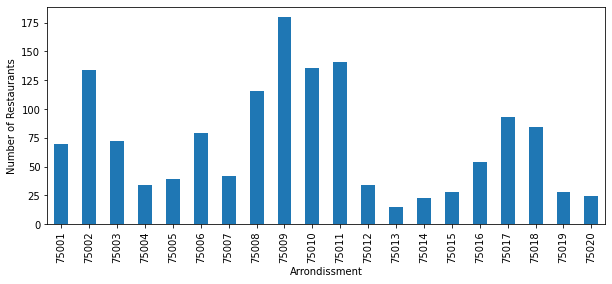

In [0]:
#arrange data for plotting (remove columns and put Arrondissment )
newtable_grouped = newtable_restos.groupby('Arrondissements').count().filter(like = '75', axis=0)['Street']

# step 2: plot data
newtable_grouped.plot(kind='bar', figsize=(10, 4))

plt.xlabel('Arrondissment') # add to x-label to the plot
plt.ylabel('Number of Restaurants') # add y-label to the plot

plt.show()

In [0]:
#group by arrondissements and filter in Paris
newtable_grouped = newtable_restos.groupby('Arrondissements').count().filter(like = '75', axis=0).reset_index(drop=False)
#keep 2 columns
newtable_grouped = newtable_grouped[['Arrondissements','Street']]
# let's rename the column so that they make sense
newtable_grouped.rename(columns={'Street':'Resto_Count'}, inplace=True)

In [0]:
newtable_grouped.to_csv("{}/newtable_grouped.csv".format(save_path), index=False)

In [0]:
newtable_grouped

,Arrondissements,Resto_Count
0,75001,70
1,75002,134
2,75003,72
3,75004,34
4,75005,39
5,75006,79
6,75007,42
7,75008,116
8,75009,180
9,75010,136


### Geolocalisation (Geocoder)

In [0]:
pip install geocoder

     |████████████████████████████████| 102kB 2.3MB/s 


In [0]:
import geocoder

In [0]:
def getcoords(names,streets,arrondissements):

  coords_list=[]

  for name, street, arrond in zip(names,streets,arrondissements):
    print(name)

    # initialize your variable to None
    lat_lng_coords = None
    
    # loop until you get the coordinates
    while(lat_lng_coords is None):
      g = geocoder.google('{}, Paris, France'.format(street))
      lat_lng_coords = g.latlng
    
    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]

    #Append the list
    coords_list.append([(
        name,
        street,
        arrond,
        latitude,
        longitude
    )])
  
  #Append the DataFrame
  coords=pd.DataFrame([item for coords_list in coords_list for item in coords_list])
  coords.columns = ['Names','Streets','Arrondissements','Latitudes','Longitudes']


  return(coords)

In [0]:
df_paris2 = getcoords(names=df['Names'],
                  streets=df['Street'],
                  arrondissements=df['Arrondissements'])

Ellis Gourmet Burger


KeyboardInterrupt: ignored

### Geolocalisation (Geocode)

In [0]:
address = 'Paris'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Paris are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Paris are 48.8566969, 2.3514616.


In [0]:
def getloc(names, places):

  loc_list = []
  for name, place in zip (names, places):
    loc = geolocator.geocode('{}, Paris, France'.format(place))
    try:
      lat = loc.latitude
      lon = loc.longitude
    except:
      lat = None
      lon = None

    loc_list.append([(name,lat,lon)])
    print(place)

  df_loc= pd.DataFrame([item for loc_list in loc_list for item in loc_list])
  df_loc.columns = ['Name', 
                  'Latitude', 
                  'Longitude']
    
  return(df_loc)

In [0]:
df_paris = getloc(names=df['Names'],
                  places=df['Street'])

58, Rue du Faubourg Saint-Antoine
18 rue Fabert
22 rue Surcourf
18 rue Troyon
4, bis rue Saint Sauveur
137 rue Montmartre
4, rue de Navarin
102 ter, rue Lepic
1, bis rue de Paradis
5, rue Caron
133 Bd Haussmann
4 rue Toullier
3 rue de la bourse
ChÃ¢teau de Versailles Pavillon Dufour - 1er Ã©tage  Place dâArmes
13 rue Beautreillis
65 rue de Charonne
103 rue des Dames
24 place des Vosges
7 Rue Boulle
71 rue des Dames
34 Rue Jean Mermoz
23 rue de Cotte
63 rue Jean Baptiste Pigalle
8 Bis Rue Sedaine
23-25 rue EugÃ¨ne CarriÃ¨re
172 bis rue Faubourg Saint Antoine
42, Cour Saint Emilion
41 rue Notre-Dame de Nazareth
Quai de l'hÃ´tel de ville
29-33 avenue Daumesnil
19 boulevard de la Tour-Maubourg
8 rue Lamarck
28 rue Saint-Roch
5 rue de l'Abbaye
9 rue Brochant
124 avenue parmentier
31, rue LinnÃ©
37 quai de Valmy
Port Debilly  EntrÃ©e face au 26 avenue de New York
6 rue du Faubourg Montmartre
22 rue la BruyÃ¨re
28 rue de la Grande Truanderie
39 rue Mazarine
142 rue Saint-Denis
6-8 Square Sa

In [0]:
df_paris.head()

,Name,Latitude,Longitude
0,Ellis Gourmet Burger,48.851928,2.373238
1,Divellec,48.860971,2.311373
2,Tomy(&co),NaN,NaN
3,La scÃ¨ne ThÃ©lÃ¨me,48.876259,2.295158
4,Klay Saint-Sauveur,NaN,NaN


In [0]:
df_paris.shape

(76, 3)

In [0]:
place='22 rue Surcourf'
loc = None
while(loc is None):
  loc = geolocator.geocode('{}, 75007 Paris, France'.format(place))

In [0]:
lat=loc.latitude
lon= loc.longitude
label='Ellis Gourmet Burger'
print('The geograpical coordinate of {} are {}, {}.'.format(label,lat, lon))

AttributeError: ignored

In [0]:
df_paris.dropna(subset=["Latitude"],axis=0, inplace=True)
df_paris.reset_index(drop=True, inplace=True)

In [0]:
df_paris.shape

(76, 3)

In [0]:
df_paris.head()

,Name,Latitude,Longitude
0,Ellis Gourmet Burger,48.851928,2.373238
1,Divellec,48.860971,2.311373
2,La scÃ¨ne ThÃ©lÃ¨me,48.876259,2.295158
3,Mardi crÃªperie urbaine Bourse,48.869899,2.342651
4,Belle Maison,48.879530,2.339634


### Visualization

In [0]:
# create map
map_newtable = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to the map

for lat, lon, name in zip(df_paris['Latitude'], df_paris['Longitude'], df_paris['Name']):
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=name,
        color='Blue',
        fill=True,
        fill_color='Blue',
        fill_opacity=0.7).add_to(map_newtable)
       
map_newtable

## Etalab

API : https://cadastre.data.gouv.fr/data/etalab-dvf/latest/csv/2019/communes/75/

In [0]:
#code INSEE de la commune (PARIS 01)
year = 2019
department = 75
code_commune = 75101
path = 'https://cadastre.data.gouv.fr/data/etalab-dvf/latest/csv/{}/communes/{}/{}.csv'.format(year,department,code_commune)

df_Paris01 = pd.read_csv(path)
df_Paris01.head()

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
0,2019-1062991,2019-01-04,1,Vente,1196000.0,17,NaN,RUE DUPHOT,2999,75001,75101,Paris 1er Arrondissement,75,NaN,NaN,75101000BC0014,NaN,NaN,21.0,106.85,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,112.0,3.0,NaN,NaN,NaN,NaN,NaN,2.325288,48.868416
1,2019-1063003,2019-01-07,1,Vente,1935600.0,24,NaN,RUE DE MONTPENSIER,6528,75001,75101,Paris 1er Arrondissement,75,NaN,NaN,75101000AV0033,NaN,NaN,9.0,64.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,66.0,2.0,NaN,NaN,NaN,NaN,NaN,2.337119,48.865114
2,2019-1063004,2019-01-08,1,Vente,90000.0,24,NaN,RUE DE MONTPENSIER,6528,75001,75101,Paris 1er Arrondissement,75,NaN,NaN,75101000AV0033,NaN,NaN,14.0,4.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.337119,48.865114
3,2019-1063005,2019-01-09,1,Vente,209000.0,56,NaN,RUE DE RICHELIEU,8212,75001,75101,Paris 1er Arrondissement,75,NaN,NaN,75101000AV0063,NaN,NaN,60.0,15.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,19.0,1.0,NaN,NaN,NaN,NaN,NaN,2.337476,48.866524
4,2019-1063007,2019-01-11,1,Vente,43000.0,1,NaN,RUE DES PYRAMIDES,7902,75001,75101,Paris 1er Arrondissement,75,NaN,NaN,75101000AX0010,NaN,NaN,105.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.332096,48.864313


In [0]:
#code INSEE de la commune (PARIS 01)
year = 2019
department = 75
code_commune = 75101
path = 'https://cadastre.data.gouv.fr/data/etalab-dvf/latest/csv/{}/communes/{}/{}.csv'.format(year,department,code_commune)
df_Paris = pd.read_csv(path)

print(year)
print(code_commune)

#scroll all arrondissements
for arrond in range (75102,75121):
  path = 'https://cadastre.data.gouv.fr/data/etalab-dvf/latest/csv/{}/communes/{}/{}.csv'.format(year,department,arrond)
  df = pd.read_csv(path)
  #append dataframe
  df_Paris = df_Paris.append(df, ignore_index = True)
  print(arrond)

year = 2018
print(year)
for arrond in range (75101,75121):
  path = 'https://cadastre.data.gouv.fr/data/etalab-dvf/latest/csv/{}/communes/{}/{}.csv'.format(year,department,arrond)
  df = pd.read_csv(path)
  #append dataframe
  df_Paris = df_Paris.append(df, ignore_index = True)
  print(arrond)

df_Paris.to_csv("df_Paris.csv", index=False)

2019
75101
75102
75103
75104
75105
75106
75107
75108
75109
75110
75111
75112
75113
75114
75115
75116
75117
75118
75119
75120
2018
75101
75102
75103
75104
75105
75106
75107
75108
75109
75110
75111
75112
75113
75114
75115
75116
75117
75118
75119
75120


In [0]:
df_Paris.shape

(125801, 40)

In [0]:
df_Paris.head()

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
0,2019-1062991,2019-01-04,1,Vente,1196000.0,17.0,NaN,RUE DUPHOT,2999,75001.0,75101,Paris 1er Arrondissement,75,NaN,NaN,75101000BC0014,NaN,NaN,21,106.85,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,112.0,3.0,NaN,NaN,NaN,NaN,NaN,2.325288,48.868416
1,2019-1063003,2019-01-07,1,Vente,1935600.0,24.0,NaN,RUE DE MONTPENSIER,6528,75001.0,75101,Paris 1er Arrondissement,75,NaN,NaN,75101000AV0033,NaN,NaN,9,64.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,66.0,2.0,NaN,NaN,NaN,NaN,NaN,2.337119,48.865114
2,2019-1063004,2019-01-08,1,Vente,90000.0,24.0,NaN,RUE DE MONTPENSIER,6528,75001.0,75101,Paris 1er Arrondissement,75,NaN,NaN,75101000AV0033,NaN,NaN,14,4.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.337119,48.865114
3,2019-1063005,2019-01-09,1,Vente,209000.0,56.0,NaN,RUE DE RICHELIEU,8212,75001.0,75101,Paris 1er Arrondissement,75,NaN,NaN,75101000AV0063,NaN,NaN,60,15.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,19.0,1.0,NaN,NaN,NaN,NaN,NaN,2.337476,48.866524
4,2019-1063007,2019-01-11,1,Vente,43000.0,1.0,NaN,RUE DES PYRAMIDES,7902,75001.0,75101,Paris 1er Arrondissement,75,NaN,NaN,75101000AX0010,NaN,NaN,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.332096,48.864313


In [0]:
#remove duplicate id_mutation
df_Paris.drop_duplicates(subset ="id_mutation", keep = False, inplace = True)
#filter only on Appartement
df_Paris_set = df_Paris[df_Paris.type_local == 'Appartement'].reset_index(drop=True)
#take nombre_lots=1
df_Paris_set = df_Paris_set[df_Paris_set.nombre_lots == 1].reset_index(drop=True)
#take mutation without ground
df_Paris_set = df_Paris_set[df_Paris_set.code_nature_culture != "S"].reset_index(drop=True)
#take mutation about vente
df_Paris_set = df_Paris_set[df_Paris_set.nature_mutation == "Vente"].reset_index(drop=True)

#convert date to pd.datetime
import datetime
df_Paris_set['date_mutation']= pd.to_datetime(df_Paris_set['date_mutation'],format="%Y-%m-%d")

# for sake of consistency, let's also make all column labels of type string
df_Paris_set.columns = list(map(str, df_Paris_set.columns))

# add column that calculs the cost by m2
df_Paris_set['price_m2'] = df_Paris_set['valeur_fonciere']/df_Paris_set['surface_reelle_bati']

# add column that gives distance to Paris centre
df_Paris_set['radius'] = distance(lat1=df_Paris_set['latitude'],lon1=df_Paris_set['longitude'])

In [0]:
df_Paris_set.shape

(23275, 42)

(0.0, 267105.34753196023)

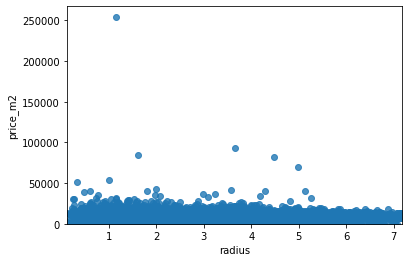

In [0]:
# Radius as potential predictor variable of price
sns.regplot(x="radius", y="price_m2", data=df_Paris_set)
plt.ylim(0,)

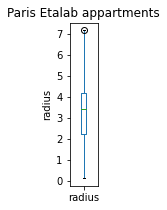

In [0]:
df_Paris_set['radius'].plot(kind='box', figsize=(0.5, 3))

plt.title('Paris Etalab appartments')
plt.ylabel('radius')

plt.show()

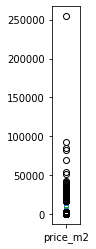

In [0]:
df_Paris_set['price_m2'].plot(kind='box', figsize=(0.5, 4))

plt.show()

In [0]:
# add column that gives Z score on the price by meter square
df_Paris_set['z_score'] = (df_Paris_set['price_m2']-df_Paris_set['price_m2'].mean())/df_Paris_set['price_m2'].std(ddof=0)

In [0]:
df_Paris_set['z_score'].head()

0    4.796985
1    0.385810
2    0.511387
3    0.280268
4    2.261525
Name: z_score, dtype: float64

In [0]:
df_Paris_set.head()

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude,price_m2,radius,z_score
0,2019-1063003,2019-01-07,1,Vente,1935600.0,24.0,NaN,RUE DE MONTPENSIER,6528,75001.0,75101,Paris 1er Arrondissement,75,NaN,NaN,75101000AV0033,NaN,NaN,9,64.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,66.0,2.0,NaN,NaN,NaN,NaN,NaN,2.337119,48.865114,29327.272727,1.406001,4.796985
1,2019-1063005,2019-01-09,1,Vente,209000.0,56.0,NaN,RUE DE RICHELIEU,8212,75001.0,75101,Paris 1er Arrondissement,75,NaN,NaN,75101000AV0063,NaN,NaN,60,15.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,19.0,1.0,NaN,NaN,NaN,NaN,NaN,2.337476,48.866524,11000.000000,1.496914,0.385810
2,2019-1063010,2019-01-11,1,Vente,530000.0,20.0,NaN,QUAI DE LA MEGISSERIE,6249,75001.0,75101,Paris 1er Arrondissement,75,NaN,NaN,75101000AN0100,NaN,NaN,56,44.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,46.0,2.0,NaN,NaN,NaN,NaN,NaN,2.343732,48.858427,11521.739130,0.597316,0.511387
3,2019-1063034,2019-01-04,1,Vente,1975000.0,1.0,NaN,RUE DES INNOCENTS,4718,75001.0,75101,Paris 1er Arrondissement,75,NaN,NaN,75101000AO0079,NaN,NaN,80,185.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,187.0,6.0,NaN,NaN,NaN,NaN,NaN,2.348171,48.860291,10561.497326,0.466550,0.280268
4,2019-1063053,2019-01-11,1,Vente,545000.0,17.0,NaN,PL DAUPHINE,2594,75001.0,75101,Paris 1er Arrondissement,75,NaN,NaN,75101000AL0020,NaN,NaN,18,30.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,29.0,2.0,NaN,NaN,NaN,NaN,NaN,2.342125,48.856426,18793.103448,0.683732,2.261525


In [0]:
df_Paris_set[df_Paris_set.z_score >=3].count()

id_mutation                     104
date_mutation                   104
numero_disposition              104
nature_mutation                 104
valeur_fonciere                 104
adresse_numero                  104
adresse_suffixe                   3
adresse_nom_voie                104
adresse_code_voie               104
code_postal                     104
code_commune                    104
nom_commune                     104
code_departement                104
ancien_code_commune               0
ancien_nom_commune                0
id_parcelle                     104
ancien_id_parcelle                0
numero_volume                     0
lot1_numero                     104
lot1_surface_carrez              85
lot2_numero                       0
lot2_surface_carrez               0
lot3_numero                       0
lot3_surface_carrez               0
lot4_numero                       0
lot4_surface_carrez               0
lot5_numero                       0
lot5_surface_carrez         

In [0]:
df_Paris_set.to_csv("df_Paris_set.csv", index=False)

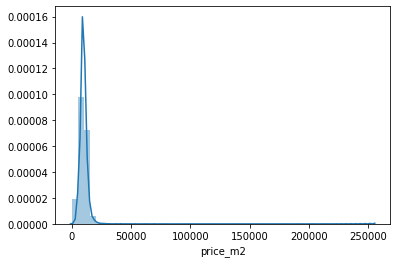

In [0]:
# gaussian
sns.distplot(df_Paris_set['price_m2'])

### Z-Score

In [0]:
#remove outliers
df_Paris_z = df_Paris_set[df_Paris_set.z_score < 3].reset_index(drop=True)

In [0]:
#add objectid column
df_Paris_z['objectid'] = (df_Paris_z['code_postal']-75000).round(0)

In [0]:
df_Paris_z.shape

(23157, 44)

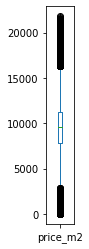

In [0]:
df_Paris_z['price_m2'].plot(kind='box', figsize=(0.5, 4))

plt.show()

In [0]:
df_Paris_z.sort_values(by="price_m2",ascending=True,inplace=True)

In [0]:
df_Paris_z.head()

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude,price_m2,radius,z_score,objectid
6513,2019-1084992,2019-06-19,1,Vente,1.0,19.0,NaN,RUE DE PRESBOURG,7798,75016.0,75116,Paris 16e Arrondissement,75,NaN,NaN,75116000FB0020,NaN,NaN,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,256.0,7.0,NaN,NaN,NaN,NaN,NaN,2.292436,48.873941,0.003906,4.724203,-2.261769,16.0
18482,2018-1391367,2018-01-08,1,Vente,1.0,2.0,NaN,AV EMILE BERGERAT,3209,75016.0,75116,Paris 16e Arrondissement,75,NaN,NaN,75116000BU0001,NaN,NaN,168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,195.0,6.0,NaN,NaN,NaN,NaN,NaN,2.271384,48.852985,0.005128,5.873223,-2.261768,16.0
11418,2018-1366330,2018-03-19,1,Vente,1.0,60.0,NaN,RUE DE TURENNE,9506,75003.0,75103,Paris 3e Arrondissement,75,NaN,NaN,75103000AM0112,NaN,NaN,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,160.0,4.0,NaN,NaN,NaN,NaN,NaN,2.364953,48.859061,0.006250,1.021416,-2.261768,3.0
3287,2019-1071840,2019-10-07,1,Vente,1.0,17.0,B,RUE DE PARADIS,7043,75010.0,75110,Paris 10e Arrondissement,75,NaN,NaN,75110000AS0055,NaN,NaN,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,155.0,6.0,NaN,NaN,NaN,NaN,NaN,2.352941,48.874675,0.006452,2.002000,-2.261768,10.0
11498,2018-1366889,2018-06-04,1,Vente,1.0,60.0,NaN,RUE DES TOURNELLES,9382,75003.0,75103,Paris 3e Arrondissement,75,NaN,NaN,75103000AN0053,NaN,NaN,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,130.0,4.0,NaN,NaN,NaN,NaN,NaN,2.367498,48.856914,0.007692,1.173470,-2.261768,3.0


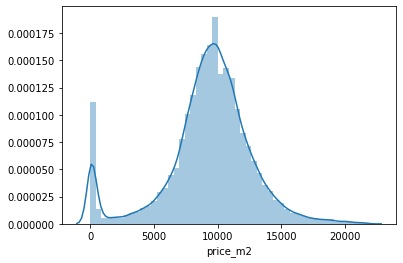

In [0]:
# gaussian
sns.distplot(df_Paris_z['price_m2'])

(0.0, 22889.9998046875)

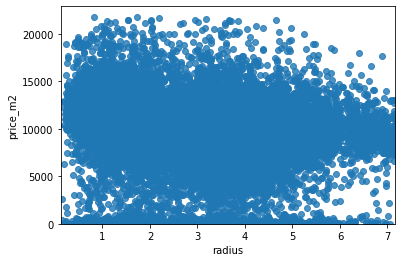

In [0]:
#Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# Radius as potential predictor variable of price
sns.regplot(x="radius", y="price_m2", data=df_Paris_z)
plt.ylim(0,)

In [0]:
df_Paris_z.to_csv("df_Paris_z.csv", index=False)

### Distribution

In [0]:
#remove distribution pic
df_Paris_clean = df_Paris_z[df_Paris_z.price_m2 > 1000].reset_index(drop=True)

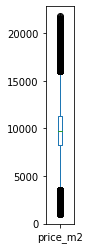

In [0]:
df_Paris_clean['price_m2'].plot(kind='box', figsize=(0.5, 4))

plt.show()

In [0]:
df_Paris_clean.shape

(21855, 44)

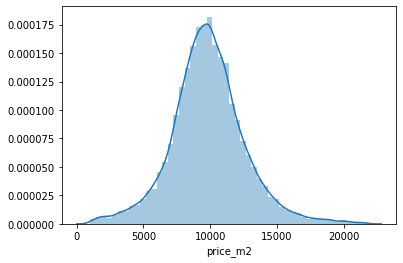

In [0]:
# gaussian
sns.distplot(df_Paris_clean['price_m2'])

In [0]:
df_Paris_clean.head()

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude,price_m2,radius,z_score,objectid
0,2018-1386759,2018-01-08,1,Vente,22015.7,10.0,NaN,RUE HENRI BOCQUILLON,4541,75015.0,75115,Paris 15e Arrondissement,75,NaN,NaN,75115000EO0014,NaN,NaN,214,21.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,22.0,1.0,NaN,NaN,NaN,NaN,NaN,2.289682,48.841481,1000.713636,4.826743,-2.020909,15.0
1,2018-1373391,2018-04-27,1,Vente,70000.0,52.0,NaN,RUE PIERRE FONTAINE,3713,75009.0,75109,Paris 9e Arrondissement,75,NaN,NaN,75109000AD0117,NaN,NaN,67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,69.0,3.0,NaN,NaN,NaN,NaN,NaN,2.333196,48.883241,1014.492754,3.239837,-2.017592,9.0
2,2018-1389953,2018-10-17,1,Vente,120000.0,18.0,NaN,RUE DU GAL BEURET,4017,75015.0,75115,Paris 15e Arrondissement,75,NaN,NaN,75115000BU0061,NaN,NaN,56,11.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,117.0,6.0,NaN,NaN,NaN,NaN,NaN,2.302384,48.841250,1025.641026,3.980708,-2.014909,15.0
3,2018-1372877,2018-03-14,2,Vente,31292.0,103.0,NaN,RUE DU FBG SAINT DENIS,3516,75010.0,75110,Paris 10e Arrondissement,75,NaN,NaN,75110000AP0054,NaN,NaN,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,30.0,2.0,NaN,NaN,NaN,NaN,NaN,2.355362,48.874950,1043.066667,2.049606,-2.010715,10.0
4,2018-1375914,2018-12-07,1,Vente,110000.0,16.0,NaN,RUE DE L ECHIQUIER,3084,75010.0,75110,Paris 10e Arrondissement,75,NaN,NaN,75110000AV0012,NaN,NaN,5,105.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,105.0,4.0,NaN,NaN,NaN,NaN,NaN,2.351752,48.871435,1047.619048,1.638940,-2.009619,10.0


(0.0, 1866.0883042060807)

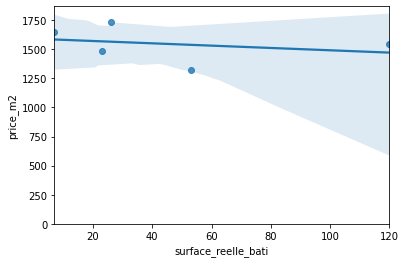

In [0]:
# Radius as potential predictor variable of price
sns.regplot(x="surface_reelle_bati", y='price_m2', data=df_Paris_clean.set_index('code_postal').filter(like = '75020', axis=0).head())
plt.ylim(0,)

In [0]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**

# Subplot 1: Box plot
sns.regplot(x="surface_reelle_bati", y='price_m2', data=df_Paris_clean.filter)
plt.ylim(0,)
df_CI.plot(kind='box', color='blue', vert=False, figsize=(20, 6), ax=ax0) # add to subplot 1
ax0.set_title('Box Plots of Immigrants from China and India (1980 - 2013)')
ax0.set_xlabel('Number of Immigrants')
ax0.set_ylabel('Countries')

# Subplot 2: Line plot
df_CI.plot(kind='line', figsize=(20, 6), ax=ax1) # add to subplot 2
ax1.set_title ('Line Plots of Immigrants from China and India (1980 - 2013)')
ax1.set_ylabel('Number of Immigrants')
ax1.set_xlabel('Years')

plt.show()

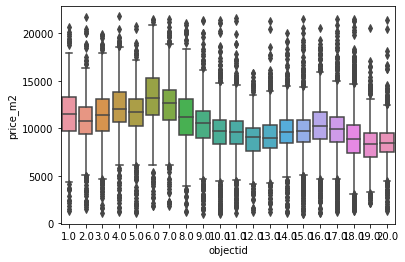

In [0]:
sns.boxplot(x="objectid", y="price_m2", data=df_Paris_clean)

In [0]:
df_Paris_clean.to_csv("df_Paris_clean.csv", index=False)

In [0]:
df_Paris_clean.groupby('code_commune', axis=0)['id_mutation'].count()

code_commune
75101     362
75102     598
75103     703
75104     462
75105     664
75106     520
75107     484
75108     446
75109     999
75110    1387
75111    1442
75112     765
75113     928
75114    1055
75115    2097
75116    1557
75117    1961
75118    2919
75119    1092
75120    1414
Name: id_mutation, dtype: int64

### Map

In [0]:
price_grouped = df_Paris_clean.groupby('code_commune', axis=0).mean().reset_index()
#select useful columns
price_grouped = price_grouped[['code_commune','code_postal','price_m2','objectid']]
#add total number of mutations
price_grouped['mutation_nbr']=df_Paris_clean.groupby('code_commune', axis=0)['id_mutation'].count().values
price_grouped

,code_commune,code_postal,price_m2,objectid,mutation_nbr
0,75101,75001.0,11417.079938,1.0,362
1,75102,75002.0,10719.073963,2.0,598
2,75103,75003.0,11273.325549,3.0,703
3,75104,75004.0,12052.749518,4.0,462
4,75105,75005.0,11512.027309,5.0,664
5,75106,75006.0,13198.114084,6.0,520
6,75107,75007.0,12463.690367,7.0,484
7,75108,75008.0,11193.764407,8.0,446
8,75109,75009.0,10320.195609,9.0,999
9,75110,75010.0,9630.028923,10.0,1387


In [0]:
price_grouped.to_csv("{}/price_grouped.csv".format(save_path), index=False)

In [0]:
price_grouped.set_index('code_commune').sort_values(by='price_m2', ascending=False)['price_m2']

code_commune
75106    13198.114084
75107    12463.690367
75104    12052.749518
75105    11512.027309
75101    11417.079938
75103    11273.325549
75108    11193.764407
75102    10719.073963
75109    10320.195609
75116    10308.345345
75117     9806.370620
75115     9679.625232
75114     9669.704384
75110     9630.028923
75111     9511.421103
75113     9113.190405
75118     8921.597262
75112     8880.822716
75120     8488.291020
75119     8253.120543
Name: price_m2, dtype: float64

In [0]:
price_grouped.shape

(20, 28)

In [0]:
# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
paris_map.choropleth(
    geo_data=arrond_geo,
    data=price_grouped,
    columns=['objectid','price_m2'],
    key_on='feature.properties.objectid',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Paris prices by m2 by Arrondissements'
)

# display map
paris_map

/usr/local/lib/python3.6/dist-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


### Map 2

In [0]:
#add administrative neighbourhoods to data
path = 'https://opendata.paris.fr/explore/dataset/quartier_paris/download/?format=csv'

df_quartier = pd.read_csv(path,error_bad_lines=False)
df_quartier.head()

b'Skipping line 3: expected 136 fields, saw 154\nSkipping line 4: expected 136 fields, saw 264\nSkipping line 5: expected 136 fields, saw 864\nSkipping line 6: expected 136 fields, saw 432\nSkipping line 7: expected 136 fields, saw 234\nSkipping line 9: expected 136 fields, saw 138\nSkipping line 10: expected 136 fields, saw 444\nSkipping line 11: expected 136 fields, saw 278\nSkipping line 16: expected 136 fields, saw 144\nSkipping line 17: expected 136 fields, saw 346\nSkipping line 18: expected 136 fields, saw 174\nSkipping line 19: expected 136 fields, saw 148\nSkipping line 20: expected 136 fields, saw 194\nSkipping line 21: expected 136 fields, saw 258\nSkipping line 28: expected 136 fields, saw 206\nSkipping line 30: expected 136 fields, saw 1420\nSkipping line 32: expected 136 fields, saw 172\nSkipping line 35: expected 136 fields, saw 264\nSkipping line 36: expected 136 fields, saw 214\nSkipping line 37: expected 136 fields, saw 194\nSkipping line 38: expected 136 fields, saw 

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,n_sq_qu;c_qu;c_quinsee;l_qu;c_ar;n_sq_ar;perimetre;surface;geom_x_y;geom
750000023;23;7510603;Notre-Dame-des-Champs;6;750000006;4559.98977263;861307.03782615;48.846427594,"2.32735687823;""{""""type"""": """"Polygon""""","""""coordinates"""": [[[2.336756578897731",48.84013064406058],[2.336729140854461,48.83965344295356],[2.336728820703796,48.83965354730361],[2.333806545408362,48.84060920565376],[2.333806456448748,48.840609236636155],[2.33107730632411,48.841511888468055],[2.330450711603929,48.84171909443279],[2.329824110310061,48.84192620893034],[2.327112303837101,48.84282277307901],[2.3271122230910652,48.842822800505125],[2.32638061829454,48.843060658091105],[2.32471189002934,48.84361526577511],[2.323890983461755,48.84388939515986],[2.323890800069642,48.8438894570789],[2.323129380053424,48.84414053483314],[2.3213253967132452,48.844735272433084],[2.320203390249648,48.84511344568527],[2.319153027255282,48.84550645090761],[2.316571525922003,48.84682460831802],[2.318043100931278,48.84733810085932],[2.318043221601835,48.84733814741461],[2.319079057823354,48.84773439185731],[2.319355218603575,48.84784504323267],[2.320083673707669,48.84818013038714],[2.320177584570482,48.84823126389148],[2.320177680647526,48.848231315700964],[2.320541155736984,48.84841994209822],[2.322133508640103,48.849249734464294],[2.322898103749189,48.84963489967507],[2.323286534962516,48.8498257694097],[2.324139714647005,48.850230265361965],[2.325273596198601,48.85069666187359],[2.326638734244415,48.85126152914954],[2.326865727976552,48.851408401655306],[2.327193140060224,48.85162533447336],[2.328418564019276,48.85182479562522],[2.329538677000945,48.8520149752803],[2.330324685782109,48.85218527426276],[2.331583280935697,48.852393777652544],[2.332017279834932,48.85247653635519],[2.331905994526561,48.851398165330345],[2.332022073723119,48.85138188842925],[2.331800377061046,48.850261693867616],[2.331654099001932,48.84841861460103],[2.331575072521067,48.847054770791836],[2.331496646834053,48.845791113015],[2.336122724245985,48.84101147780823],[2.336158716188632,48.84097686041844],[2.336194955929291,48.840946960663864],[2.336229684671605,48.84092005009821],[2.336262905125881,48.84089613053668],[2.336303673003588,48.84087121317405],[2.336344443567211,48.84084629581205],[2.336381479553637,48.84082522049256],[2.336388232068504,48.84082137898926],[2.33643504037966,48.84079845570657],[2.336438155110842,48.84079706367865],[2.3364818478030562,48.84077752539418],[2.336525637817021,48.84076157790024],[2.336575465954379,48.840743638506396],[2.336637376466927,48.840726694239265],[2.336691733751902,48.84071473371217],[2.33674760255507,48.84070476733988],[2.336789472815803,48.84070272588634],[2.336780834611949,48.840552486649806],[2.336769331206226,48.84035244981474],[2.336756578897731,"48.84013064406058]]]}"""
750000021;21;7510601;Monnaie;6;750000006;2391.1228183;293360.5723113;48.8543844036,"2.34003537113;""{""""type"""": """"Polygon""""","""""coordinates"""": [[[2.343168550439539",48.85138855000365],[2.342677870551298,48.850357652304076],[2.341305855693479,48.85088325822361],[2.341184376257707,48.85087740369368],[2.340844428336918,48.85106994891613],[2.340506889630401,48.851281585383134],[2.3402349782103,48.851470698644924],[2.339729174030643,48.85195038527006],[2.339461015584085,48.852111171502024],[2.339161019159428,48.852291044584604],[2.338941424289083,48.85242270958092],[2.33698866720655,48.852901959413856],[2.336959933858708,48.8538108882516],[2.3369724447306313,48.85392946825931],[2.336773070228429,48.855298166167096],[2.336715828494618,48.855671814471215],[2.33650811813714,48.857167042991094],[2.336497252304075,48.857228830292414],[2.336492042345277,48.857254897905236],[2.336466832897048,48.85733529690001],[2.336448665985389,48.857372013837285],[2.336426573535695,48.85740778356924],[2.336406182955341,48.85743556119926],[2.336381893810001

In [0]:
# download arrondissement geojson file
!wget --quiet  https://opendata.paris.fr/explore/dataset/quartier_paris/download/?format=geojson -O quartier.json
    
print('GeoJSON file downloaded!')

GeoJSON file downloaded!


In [0]:
quartier_geo = r'quartier.json' # geojson file

# create a plain world map
paris_map = folium.Map(location=[latitude, longitude], zoom_start=12)

In [0]:
# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
paris_map.choropleth(
    geo_data=arrond_geo,
    data=price_grouped,
    columns=['objectid','price_m2'],
    key_on='feature.properties.objectid',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Paris prices by m2 by Arrondissements'
)

# display map
paris_map

## Parks

In [0]:
path = 'https://opendata.paris.fr/explore/dataset/plan-de-voirie-emprises-espaces-verts/download/?format=csv&use_labels_for_header=true'
df_park = pd.read_csv(path, sep=';')
df_park.head()

,OBJECTID,NUM_PAVE,IGDS_LEVEL,LIB_LEVEL,LIB_CLASSE,geo_shape,geo_point_2d
0,4,011B,32,DOMAINE PUBLIC ASSIMILE PARCELLE,Emprise espace vert,"{""type"": ""Polygon"", ""coordinates"": [[[2.336790...","48.8596111133,2.3373594683"
1,90,191E,32,DOMAINE PUBLIC ASSIMILE PARCELLE,Emprise espace vert,"{""type"": ""Polygon"", ""coordinates"": [[[2.370119...","48.8831321775,2.36983981752"
2,97,192A,32,DOMAINE PUBLIC ASSIMILE PARCELLE,Emprise espace vert,"{""type"": ""Polygon"", ""coordinates"": [[[2.382319...","48.9004977752,2.38264275911"
3,100,192A,32,DOMAINE PUBLIC ASSIMILE PARCELLE,Emprise espace vert,"{""type"": ""Polygon"", ""coordinates"": [[[2.373304...","48.9008340495,2.37282182712"
4,145,123D,32,DOMAINE PUBLIC ASSIMILE PARCELLE,Emprise espace vert,"{""type"": ""Polygon"", ""coordinates"": [[[2.391792...","48.8267603066,2.39134193734"


In [0]:
df_park.shape

(973, 7)

In [0]:
# download arrondissement geojson file
!wget --quiet  https://opendata.paris.fr/explore/dataset/plan-de-voirie-emprises-espaces-verts/download/?format=geojson -O parks.json
    
print('GeoJSON file downloaded!')

GeoJSON file downloaded!


In [0]:
parks_geo = r'parks.json' # geojson file

# create a plain world map
paris_map = folium.Map(location=[latitude, longitude], zoom_start=12)

In [0]:
# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
#key_on='fields.objectid'
paris_map.choropleth(
    geo_data=parks_geo,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Paris Parks'
)

# display map
paris_map

## Métro

In [0]:
#test of the non shared API (doesn't work)
dataset = 'offre-transport-de-la-ratp-format-gtfs'
transport = 'METRO'
line = 8
path = 'https://data.ratp.fr/api/records/1.0/search/?dataset={}'.format(dataset)
resultats = requests.get(path).json()
# assign relevant part of JSON to venues
results = resultats['records']
# tranform venues into a dataframe
df_test2 = json_normalize(results)
df_test2.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  if __name__ == '__main__':


""


In [0]:
#to open "non downloaded files"
#import io
#allstops = pd.read_csv(io.BytesIO(uploaded['allstops.txt']))
allstops = pd.read_csv('allstops.txt')

In [0]:
allstops['stop_desc'].nunique()

10740

In [0]:
from google.colab import files
uploaded = files.upload()

Saving stops1.txt to stops1.txt
Saving stops2.txt to stops2.txt
Saving stops3.txt to stops3.txt
Saving stops3b.txt to stops3b.txt
Saving stops4.txt to stops4.txt
Saving stops5.txt to stops5.txt
Saving stops6.txt to stops6.txt
Saving stops7.txt to stops7.txt
Saving stops7b.txt to stops7b.txt
Saving stops8.txt to stops8.txt
Saving stops9.txt to stops9.txt
Saving stops10.txt to stops10.txt
Saving stops11.txt to stops11.txt
Saving stops12.txt to stops12.txt
Saving stops13.txt to stops13.txt
Saving stops14.txt to stops14.txt


In [0]:
#import metro line 1
line = '3b'
ratp = pd.read_csv('stops{}.txt'.format(line))
ratp['line'] = line
print(line)

line = '7b'
df = pd.read_csv('stops{}.txt'.format(line))
df['line'] = line
ratp = ratp.append(df, ignore_index = True)
print(line)

#scroll all lines
for ind in range (1,15):
  df = pd.read_csv('stops{}.txt'.format(ind))
  df['line'] = ind
  #append dataframe
  ratp = ratp.append(df, ignore_index = True)
  print(ind)

3b
7b
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [0]:
ratp.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,location_type,parent_station,line
0,2463,NaN,Saint-Fargeau,112 avenue Gambetta - 75120,48.871700,2.404299,0,NaN,3b
1,1783,NaN,Pelleport,"Paul Signac (place, en face du 125 avenue Gamb...",48.868223,2.401324,0,NaN,3b
2,1718,NaN,Saint-Fargeau,112 avenue Gambetta - 75120,48.871700,2.404299,0,NaN,3b
3,2393,NaN,Pelleport,"Paul Signac (place, en face du 125 avenue Gamb...",48.868223,2.401324,0,NaN,3b
4,1752,NaN,Porte des Lilas,Rue de Belleville - 75120,48.876938,2.406377,0,NaN,3b


In [0]:
ratp.shape

(759, 9)

In [0]:
ratp.groupby('line')['stop_name'].nunique()

line
1     25
2     25
3     25
4     27
5     22
6     28
7     38
8     38
9     37
10    23
11    13
12    29
13    32
14     9
3b     4
7b     8
Name: stop_name, dtype: int64

In [0]:
ratp['stop_name'].nunique()

302

In [0]:
ratp.to_csv("{}/ratp.csv".format(save_path), index=False)

In [0]:
#check with the wikipedia data
wiki_data = pd.read_html("https://fr.wikipedia.org/wiki/Liste_des_stations_du_m%C3%A9tro_de_Paris")[0]
wiki_data.head()

,Station,Ligne(s),Rang alpha-bétique,Date d'ouverture,Situation,Commune,Fréquentation annuelle 2018[2],Correspondance,Particularité(nom précédent),Image
0,Abbesses,NaN,1,31 octobre 1912,Souterraine,Paris 18e,"+02 450 498,",NaN,NaN,NaN
1,Alésia,NaN,2,30 octobre 1909,Souterraine,Paris 14e,"+05 113 245,",NaN,NaN,NaN
2,Alexandre Dumas,NaN,3,31 janvier 1903,Souterraine,"Paris 11e, Paris 20e","+03 676 620,",NaN,(jusqu'en 1970 : Bagnolet),NaN
3,Alma - Marceau,NaN,4,27 mai 1923,Souterraine,"Paris 8e, Paris 16e","+04 561 735,",NaN,NaN,NaN
4,Anatole France,NaN,5,24 septembre 1937,Souterraine,Levallois-Perret,"+03 734 650,",NaN,quais décalés,NaN


In [0]:
wiki_data.shape

(302, 10)

### Visualization

In [0]:
# create map
map_newtable = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to the map

for lat, lon, name in zip(ratp['stop_lat'], ratp['stop_lon'], ratp['stop_name']):
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=name,
        color='Blue',
        fill=True,
        fill_color='Blue',
        fill_opacity=0.7).add_to(map_newtable)
       
map_newtable

## Activities

In [0]:
path = 'https://opendata.paris.fr/explore/dataset/que-faire-a-paris-/download/?format=csv&use_labels_for_header=true'
df_activities = pd.read_csv(path, sep=';')
df_activities.head()

,ID,URL,Titre,Chapeau,Description,Catégorie,Mots clés,Date de début,Date de fin,Occurrences,Description de la date,Nom du lieu,Adresse du lieu,Code postal,Ville,Coordonnées géographiques,Accès PMR,Accès mal voyant,Accès mal entendant,Transport,Nom de contact,Téléphone de contact,Email de contact,Url de contact,URL Facebook associée,URL Twitter associée,Type d'accès,URL de réservation,Téléphone de réservation,Email de réservation,Type de prix,Détail du prix,Image de couverture,URL de l'image,Crédit de l'image,Texte alternatif de l'image,Programmes,Date de mise à jour
0,86934,https://quefaire.paris.fr/86934/visite-enquete...,Visite enquête : Le prisonnier de la Bastille,"Le 14 juillet 1789, Paris s’apprête à vivre l’...","<p>Cette matinée du 14 juillet, alors que l’ag...",Animations -> Loisirs / Jeux,Insolite;Ados;Plein air;En famille;Enfants,2019-08-24T12:30:00+00:00,2020-12-19T11:00:00+00:00,2019-08-24T14:30:00+02:00_2019-08-24T16:30:00+...,Le samedi 24 août 2019<br />de 14h30 à 16h30<b...,Jardin du Port de l'Arsenal,Jardin de l'Arsenal,75012,Paris,NaN,0,0,0,"Métro Bastille, Sortie 4",Agence Cultival,0825054405,contact@cultival.fr,https://www.cultival.fr/,https://www.facebook.com/cultival/,https://twitter.com/CultivalParis,reservation,https://www.cultival.fr/visites/visite-enquete...,825054405.0,contact@cultival.fr,payant,Adulte : 14€ / personne\n\nEnfant (-18 ans) : ...,https://opendata.paris.fr/api/v2/catalog/datas...,https://quefaire-api.paris.fr/images/57691,Cultival,Le prisonnier de la Bastille,NaN,2020-02-19T10:17:50+00:00
1,3030,https://quefaire.paris.fr/3030/paris-cote-obscur,Paris côté obscur,"Guidé par un conférencier, vous allez voyager ...","<p><span style=""color:rgb(0, 0, 0); font-famil...",Animations -> Visite guidée,Insolite;Ados;Plein air;En famille,2017-08-12T12:30:00+00:00,2020-12-17T19:30:00+00:00,2017-08-12T14:30:00+02:00_2017-08-12T16:00:00+...,Le samedi 12 août 2017<br />de 14h30 à 16h<br ...,Marché Maubert,place maubert,75005,Paris,"48.8501422,2.3488579",0,0,0,Ligne 10 : Maubert Mutualité (19m) Ligne 4: S...,Cultival,0825 05 44 05,contact@cultival.fr,http://www.cultival.fr,https://www.facebook.com/cultival/,https://twitter.com/CultivalParis/,reservation,https://www.cultival.fr/visites/paris-obscur/p...,825054405.0,contact@cultival.fr,payant,Adulte : 13 € / personne\n\nEnfant (-18ans) : ...,https://opendata.paris.fr/api/v2/catalog/datas...,https://quefaire-api.paris.fr/images/9280,©mrousselet,Cultival Paris cote obscur,NaN,2020-02-18T17:00:45+00:00
2,102231,https://quefaire.paris.fr/102231/th-s-s-sh-t-b...,Th/s /s Sh/t • Bigger • Volin / Supersonic - Free,Le Supersonic c’est lieu incontournable du roc...,<p>TH/S /S SH/T</p><p></p><p>Th/s /s Sh/t est ...,Concerts -> Rock,Musique,2020-05-12T18:00:00+00:00,2020-05-12T21:30:00+00:00,2020-05-12T20:00:00+02:00_2020-05-12T23:30:00+...,Le mardi 12 mai 2020<br />de 20h à 23h30<br />,SUPERSONIC,9 Rue Biscornet,75012,Paris,"48.8503272,2.3697085",0,0,0,"1, 5, 8 : Bastille (301m)\n8 : Ledru-Rollin (4...",SUPERSONIC,0146281290,communication@supersonic-club.fr,NaN,https://www.facebook.com/events/458778205004784/,NaN,libre,NaN,NaN,NaN,gratuit,NaN,https://opendata.paris.fr/api/v2/catalog/datas...,https://pro.sowprog.com/downloads?name=img_eve...,NaN,NaN,NaN,2020-02-13T14:44:51+00:00
3,101546,https://quefaire.paris.fr/101546/installation-...,INSTALLATION BY STRAKER A LA VALLÉE VILLAGE,"LA VALLÉE VILLAGE x STRAKER\n""LET YOURSELF GLO...","<p>Pour la première fois en France, le muralis...",Expositions -> Street-art,Expos;Plein air;En famille,2020-01-21T09:00:00+00:00,2020-05-31T18:00:00+00:00,2020-01-21T10:00:00+01:00_2020-01-21T20:00:00+...,"Du 21 janvier au 31 mai 2020 : <br />lundi, ma...",La Vallée Village,3 cours de la Garonne,77700,Serris,NaN,0,0,0,A,La Vallée Village,NaN,NaN,NaN,NaN,NaN,libre,NaN,NaN,NaN,gratuit,NaN,https://opendata.paris.fr/api/v2/catalog/datas...,https://quefaire-api.paris.fr/images/66462,STRAKER@LVV11,STRAKER@LVV11,NaN,2020-02-03T13:14:02+00:00
4,

In [0]:
df_activities.shape

(1080, 38)

In [0]:
df_activities['Catégorie'].nunique()

44

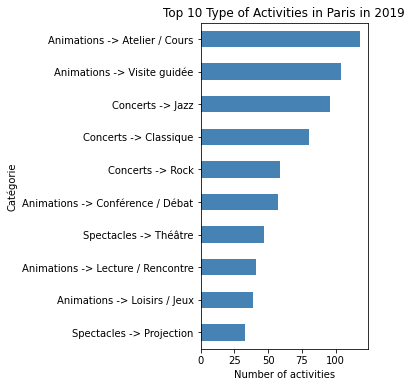

In [0]:
# create data set
df_top10 = df_activities.groupby('Catégorie', axis=0).count().sort_values(by='ID',ascending=True)['ID'].tail(10)

# generate plot
df_top10.plot(kind='barh', figsize=(3, 6), color='steelblue')
plt.xlabel('Number of activities')
plt.title('Top 10 Type of Activities in Paris in 2019')

# annotate value labels to each country
for index, value in enumerate(df_top10): 
    label = format(int(value), ',') # format int with commas

plt.show()

In [0]:
#Cleaning Arrondissement
df_activities['Code postal'].replace(75116,75016,inplace = True)

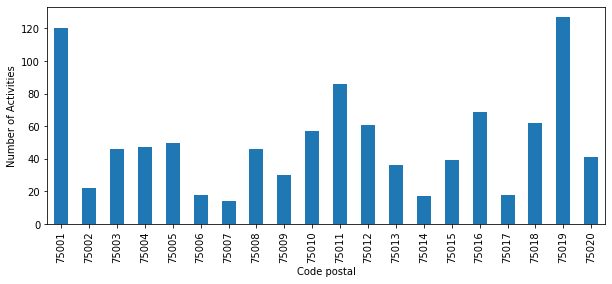

In [0]:
#arrange data for plotting (remove columns and put Arrondissment )
activities_bar = df_activities.groupby('Code postal', axis=0).count().filter(like = '750', axis=0)['ID']
activities_bar.drop(index=75000,inplace=True)
# step 2: plot data
activities_bar.plot(kind='bar', figsize=(10, 4))

plt.xlabel('Code postal') # add to x-label to the plot
plt.ylabel('Number of Activities') # add y-label to the plot

plt.show()

In [0]:
# one hot encoding
activities_onehot = pd.get_dummies(df_activities[['Catégorie']], prefix="", prefix_sep="")

# add arrondissment column back to dataframe
activities_onehot['Code postal'] = df_activities['Code postal'] 

# move arrondissment column to the first column
fixed_columns = [activities_onehot.columns[-1]] + list(activities_onehot.columns[:-1])
activities_onehot = activities_onehot[fixed_columns]

activities_onehot.head()

,Code postal,Animations -> Atelier / Cours,Animations -> Autre animation,Animations -> Balade,Animations -> Conférence / Débat,Animations -> Lecture / Rencontre,Animations -> Loisirs / Jeux,Animations -> Stage,Animations -> Visite guidée,Concerts -> Autre concert,Concerts -> Chanson française,Concerts -> Classique,Concerts -> Folk,Concerts -> Hip-Hop,Concerts -> Jazz,Concerts -> Musiques du Monde,Concerts -> Pop / Variété,Concerts -> Reggae,Concerts -> Rock,Concerts -> Soul / Funk,Concerts -> Électronique,Expositions -> Art Contemporain,Expositions -> Autre expo,Expositions -> Beaux-Arts,Expositions -> Design / Mode,Expositions -> Histoire / Civilisations,Expositions -> Illustration / BD,Expositions -> Photographie,Expositions -> Sciences / Techniques,Expositions -> Street-art,Spectacles -> Autre spectacle,Spectacles -> Cirque / Art de la Rue,Spectacles -> Danse,Spectacles -> Humour,Spectacles -> Jeune public,Spectacles -> Opéra / Musical,Spectacles -> Projection,Spectacles -> Théâtre,Événements -> Autre événement,Événements -> Brocante / Marché,Événements -> Festival / Cycle,Événements -> Fête / Parade,Événements -> Salon,Événements -> Soirée / Bal,Événements -> Événement sportif
0,75012,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,75005,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,75012,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,77700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,93420,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [0]:
activities_grouped = activities_onehot.groupby('Code postal', axis=0).mean().filter(like = '750', axis=0).reset_index()
activities_grouped.drop(index=0,inplace=True)
activities_grouped.reset_index(drop=True,inplace=True)
activities_grouped

,Code postal,Animations -> Atelier / Cours,Animations -> Autre animation,Animations -> Balade,Animations -> Conférence / Débat,Animations -> Lecture / Rencontre,Animations -> Loisirs / Jeux,Animations -> Stage,Animations -> Visite guidée,Concerts -> Autre concert,Concerts -> Chanson française,Concerts -> Classique,Concerts -> Folk,Concerts -> Hip-Hop,Concerts -> Jazz,Concerts -> Musiques du Monde,Concerts -> Pop / Variété,Concerts -> Reggae,Concerts -> Rock,Concerts -> Soul / Funk,Concerts -> Électronique,Expositions -> Art Contemporain,Expositions -> Autre expo,Expositions -> Beaux-Arts,Expositions -> Design / Mode,Expositions -> Histoire / Civilisations,Expositions -> Illustration / BD,Expositions -> Photographie,Expositions -> Sciences / Techniques,Expositions -> Street-art,Spectacles -> Autre spectacle,Spectacles -> Cirque / Art de la Rue,Spectacles -> Danse,Spectacles -> Humour,Spectacles -> Jeune public,Spectacles -> Opéra / Musical,Spectacles -> Projection,Spectacles -> Théâtre,Événements -> Autre événement,Événements -> Brocante / Marché,Événements -> Festival / Cycle,Événements -> Fête / Parade,Événements -> Salon,Événements -> Soirée / Bal,Événements -> Événement sportif
0,75001,0.108333,0.016667,0.000000,0.033333,0.016667,0.050000,0.008333,0.091667,0.016667,0.000000,0.025000,0.000000,0.000000,0.533333,0.000000,0.008333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016667,0.008333,0.000000,0.016667,0.000000,0.000000,0.000000,0.000000,0.008333,0.008333,0.000000,0.000000,0.000000,0.008333,0.008333,0.000000,0.000000,0.016667,0.000000,0.000000,0.000000,0.000000
1,75002,0.090909,0.000000,0.000000,0.000000,0.000000,0.181818,0.000000,0.090909,0.000000,0.000000,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.045455,0.000000,0.000000,0.181818,0.000000,0.136364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.136364,0.000000
2,75003,0.152174,0.021739,0.000000,0.021739,0.065217,0.043478,0.000000,0.000000,0.000000,0.000000,0.086957,0.000000,0.000000,0.021739,0.000000,0.000000,0.000000,0.043478,0.000000,0.000000,0.130435,0.108696,0.043478,0.000000,0.000000,0.000000,0.130435,0.000000,0.000000,0.021739,0.000000,0.000000,0.000000,0.065217,0.000000,0.000000,0.021739,0.000000,0.000000,0.000000,0.000000,0.021739,0.000000,0.000000
3,75004,0.148936,0.021277,0.000000,0.000000,0.021277,0.085106,0.000000,0.127660,0.000000,0.000000,0.000000,0.021277,0.000000,0.000000,0.000000,0.021277,0.000000,0.000000,0.000000,0.000000,0.042553,0.000000,0.000000,0.000000,0.063830,0.000000,0.085106,0.000000,0.000000,0.000000,0.000000,0.000000,0.042553,0.042553,0.000000,0.000000,0.255319,0.000000,0.000000,0.021277,0.000000,0.000000,0.000000,0.000000
4,75005,0.060000,0.040000,0.000000,0.020000,0.420000,0.120000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060000,0.020000,0.000000,0.040000,0.020000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.020000,0.020000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000
5,75006,0.055556,0.000000,0.000000,0.277778,0.000000,0.055556,0.111111,0.277778,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000
6,75007,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.285714,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.214286,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000

In [0]:
#function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [0]:
#dataframe with top 5 activities
num_top_activities = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Code postal']
for ind in np.arange(num_top_activities):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
activities_sorted = pd.DataFrame(columns=columns)
activities_sorted['Code postal'] = activities_grouped['Code postal']

for ind in np.arange(activities_grouped.shape[0]):
    activities_sorted.iloc[ind, 1:] = return_most_common_venues(activities_grouped.iloc[ind, :], num_top_activities)

In [0]:
#add total number of activities
activities_sorted['activities_count'] = activities_bar.values

In [0]:
activities_sorted

,Code postal,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,activities_count
0,75001,Concerts -> Jazz,Animations -> Atelier / Cours,Animations -> Visite guidée,Animations -> Loisirs / Jeux,Animations -> Conférence / Débat,120
1,75002,Animations -> Loisirs / Jeux,Spectacles -> Humour,Événements -> Soirée / Bal,Spectacles -> Opéra / Musical,Animations -> Atelier / Cours,22
2,75003,Animations -> Atelier / Cours,Expositions -> Photographie,Expositions -> Art Contemporain,Expositions -> Autre expo,Concerts -> Classique,46
3,75004,Spectacles -> Théâtre,Animations -> Atelier / Cours,Animations -> Visite guidée,Animations -> Loisirs / Jeux,Expositions -> Photographie,47
4,75005,Animations -> Lecture / Rencontre,Animations -> Loisirs / Jeux,Animations -> Visite guidée,Expositions -> Autre expo,Animations -> Atelier / Cours,50
5,75006,Animations -> Visite guidée,Animations -> Conférence / Débat,Concerts -> Classique,Événements -> Soirée / Bal,Animations -> Stage,18
6,75007,Animations -> Visite guidée,Expositions -> Beaux-Arts,Expositions -> Art Contemporain,Événements -> Autre événement,Expositions -> Histoire / Civilisations,14
7,75008,Spectacles -> Projection,Animations -> Conférence / Débat,Concerts -> Classique,Expositions -> Beaux-Arts,Animations -> Atelier / Cours,46
8,75009,Animations -> Visite guidée,Spectacles -> Projection,Animations -> Atelier / Cours,Concerts -> Hip-Hop,Animations -> Loisirs / Jeux,30
9,75010,Animations -> Atelier / Cours,Concerts -> Jazz,Animations -> Lecture / Rencontre,Animations -> Visite guidée,Expositions -> Illustration / BD,57


In [0]:
activities_sorted.to_csv("{}/activities_sorted.csv".format(save_path), index=False)

## Population

In [0]:
from google.colab import files
uploaded = files.upload()

Saving Population.csv to Population.csv


In [0]:
population = pd.read_csv('Population.csv')
population

,Code postal,Nom de la commune,Population municipale 2019 (Pop légale 2016),Population municipale 2018 (Pop légale 2015),Population municipale 2016 (Pop légale 2013),Progression sur 1 an,Progression sur 3 ans,Progression en valeur absolue sur 3 ans
0,75010,Paris 10e Arrondissement,91932,91770,92494,0.18,-0.61,-562
1,75011,Paris 11e Arrondissement,147017,149834,153461,-1.88,-4.20,-6444
2,75012,Paris 12e Arrondissement,141494,142340,144719,-0.59,-2.23,-3225
3,75013,Paris 13e Arrondissement,181552,183216,183713,-0.91,-1.18,-2161
4,75014,Paris 14e Arrondissement,137105,139992,140799,-2.06,-2.62,-3694
5,75015,Paris 15e Arrondissement,233484,234994,237120,-0.64,-1.53,-3636
6,75016,Paris 16e Arrondissement,165446,165487,166552,-0.02,-0.66,-1106
7,75017,Paris 17e Arrondissement,167835,168533,170077,-0.41,-1.32,-2242
8,75018,Paris 18e Arrondissement,195060,197580,199519,-1.28,-2.23,-4459
9,75019,Paris 19e Arrondissement,186393,185654,185953,0.40,0.24,440


In [0]:
population_clean = pd.DataFrame(columns={'Code postal','population_count'})
population_clean['Code postal'] = population['Code postal']
population_clean['population_count'] = population ['Population municipale 2019 (Pop légale 2016)']
population_clean.to_csv("{}/population.csv".format(save_path), index=False)

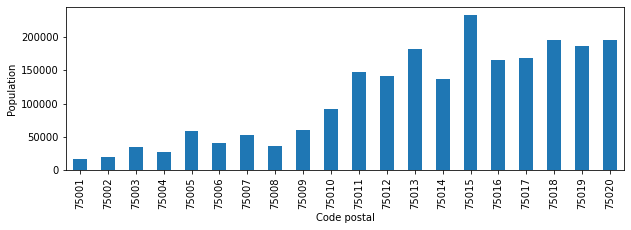

In [0]:
#arrange data for plotting (remove columns and put Arrondissment )
population_bar = population.sort_values(by="Code postal",ascending=True)
population_bar = population_bar.set_index('Code postal')
population_bar = population_bar['Population municipale 2019 (Pop légale 2016)']

# step 2: plot data
population_bar.plot(kind='bar', figsize=(10, ))

plt.xlabel('Code postal') # add to x-label to the plot
plt.ylabel('Population') # add y-label to the plot

plt.show()

# Correlation

In [0]:
#not finished
df_park = pd.read_csv("newtable_grouped.csv")
df_metro = pd.read_csv("newtable_grouped.csv")

In [0]:
df_resto = pd.read_csv("{}/newtable_grouped.csv".format(save_path))
df_price = pd.read_csv("{}/price_grouped.csv".format(save_path))
df_activities = pd.read_csv("{}/activities_sorted.csv".format(save_path))
df_population = pd.read_csv("{}/population.csv".format(save_path))

In [0]:
df_work = df_price.merge(df_resto,left_on='code_postal', right_on='Arrondissements', how='outer')
df_work = df_work.merge(df_activities,left_on='code_postal', right_on='Code postal', how='outer')
df_work = df_work.merge(df_population,left_on='code_postal', right_on='Code postal', how='outer')
df_work.drop(labels={'code_commune','Arrondissements','Code postal_x','Code postal_y'}, axis=1,inplace=True)

In [0]:
df_work

,code_postal,price_m2,objectid,mutation_nbr,Resto_Count,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,activities_count,population_count
0,75001.0,11417.079938,1.0,362,70,Concerts -> Jazz,Animations -> Atelier / Cours,Animations -> Visite guidée,Animations -> Loisirs / Jeux,Animations -> Conférence / Débat,120,16252
1,75002.0,10719.073963,2.0,598,134,Animations -> Loisirs / Jeux,Spectacles -> Humour,Événements -> Soirée / Bal,Spectacles -> Opéra / Musical,Animations -> Atelier / Cours,22,20260
2,75003.0,11273.325549,3.0,703,72,Animations -> Atelier / Cours,Expositions -> Photographie,Expositions -> Art Contemporain,Expositions -> Autre expo,Concerts -> Classique,46,34788
3,75004.0,12052.749518,4.0,462,34,Spectacles -> Théâtre,Animations -> Atelier / Cours,Animations -> Visite guidée,Animations -> Loisirs / Jeux,Expositions -> Photographie,47,27487
4,75005.0,11512.027309,5.0,664,39,Animations -> Lecture / Rencontre,Animations -> Loisirs / Jeux,Animations -> Visite guidée,Expositions -> Autre expo,Animations -> Atelier / Cours,50,59108
5,75006.0,13198.114084,6.0,520,79,Animations -> Visite guidée,Animations -> Conférence / Débat,Concerts -> Classique,Événements -> Soirée / Bal,Animations -> Stage,18,40916
6,75007.0,12463.690367,7.0,484,42,Animations -> Visite guidée,Expositions -> Beaux-Arts,Expositions -> Art Contemporain,Événements -> Autre événement,Expositions -> Histoire / Civilisations,14,52512
7,75008.0,11193.764407,8.0,446,116,Spectacles -> Projection,Animations -> Conférence / Débat,Concerts -> Classique,Expositions -> Beaux-Arts,Animations -> Atelier / Cours,46,36453
8,75009.0,10320.195609,9.0,999,180,Animations -> Visite guidée,Spectacles -> Projection,Animations -> Atelier / Cours,Concerts -> Hip-Hop,Animations -> Loisirs / Jeux,30,59629
9,75010.0,9630.028923,10.0,1387,136,Animations -> Atelier / Cours,Concerts -> Jazz,Animations -> Lecture / Rencontre,Animations -> Visite guidée,Expositions -> Illustration / BD,57,91932


(0.0, 248724.71059957298)

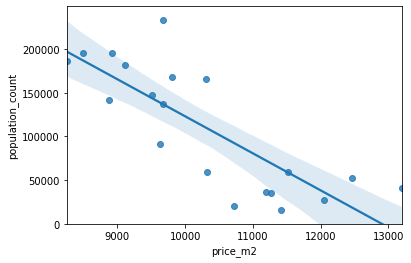

In [0]:
# Radius as potential predictor variable of price
sns.regplot(x="price_m2", y="population_count", data=df_work)
plt.ylim(0,)

(0.0, 3078.7131371610844)

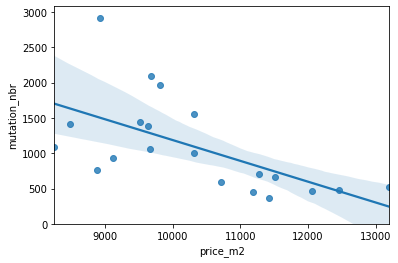

In [0]:
# Radius as potential predictor variable of price
sns.regplot(x="price_m2", y="mutation_nbr", data=df_work)
plt.ylim(0,)

(0.0, 148.4)

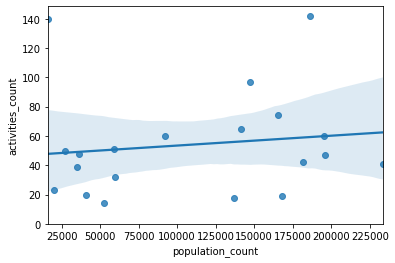

In [0]:
# Radius as potential predictor variable of price
sns.regplot(x="population_count", y="activities_count", data=df_work)
plt.ylim(0,)

(0.0, 188.25)

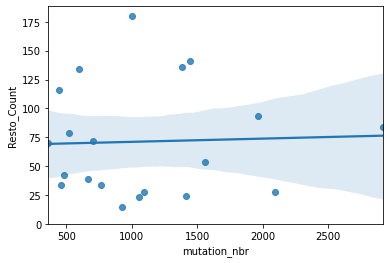

In [0]:
# Resto vs Mutation
sns.regplot(x="mutation_nbr", y="Resto_Count", data=df_work)
plt.ylim(0,)

In [0]:
df_work.corr()

,code_commune,code_postal,price_m2,objectid,mutation_nbr,Arrondissements,Resto_Count,Code postal_x,activities_count,Code postal_y,population_count
code_commune,1.000000,1.000000,-0.783484,1.000000,0.741885,1.000000,-0.286134,1.000000,0.091323,1.000000,0.925434
code_postal,1.000000,1.000000,-0.783484,1.000000,0.741885,1.000000,-0.286134,1.000000,0.091323,1.000000,0.925434
price_m2,-0.783484,-0.783484,1.000000,-0.783484,-0.607681,-0.783484,0.117193,-0.783484,-0.317882,-0.783484,-0.805515
objectid,1.000000,1.000000,-0.783484,1.000000,0.741885,1.000000,-0.286134,1.000000,0.091323,1.000000,0.925434
mutation_nbr,0.741885,0.741885,-0.607681,0.741885,1.000000,0.741885,0.038542,0.741885,0.006362,0.741885,0.780678
Arrondissements,1.000000,1.000000,-0.783484,1.000000,0.741885,1.000000,-0.286134,1.000000,0.091323,1.000000,0.925434
Resto_Count,-0.286134,-0.286134,0.117193,-0.286134,0.038542,-0.286134,1.000000,-0.286134,-0.064183,-0.286134,-0.377991
Code postal_x,1.000000,1.000000,-0.783484,1.000000,0.741885,1.000000,-0.286134,1.000000,0.193931,1.000000,0.925434
activities_count,0.091323,0.091323,-0.317882,0.091323,0.006362,0.091323,-0.064183,0.193931,1.000000,0.091323,0.133874
Code postal_y,1.000000,1.000000,-0.783484,1.000000,0.741885,1.000000,-0.286134,1.000000,0.091323,1.000000,0.925434


# Clusterization

In [0]:
#create clustering dataset
input_clus1 = df_price.merge(df_population,left_on='code_postal', right_on='Code postal', how='outer')
input_clus = input_clus1.merge(activities_grouped,left_on='code_postal', right_on='Code postal', how='outer')
input_clus.drop(labels={'mutation_nbr','code_commune','code_postal','objectid','Code postal_x','Code postal_y'}, axis=1,inplace=True)
input_clus

,price_m2,population_count,Animations -> Atelier / Cours,Animations -> Autre animation,Animations -> Balade,Animations -> Conférence / Débat,Animations -> Lecture / Rencontre,Animations -> Loisirs / Jeux,Animations -> Stage,Animations -> Visite guidée,Concerts -> Autre concert,Concerts -> Chanson française,Concerts -> Classique,Concerts -> Folk,Concerts -> Hip-Hop,Concerts -> Jazz,Concerts -> Musiques du Monde,Concerts -> Pop / Variété,Concerts -> Reggae,Concerts -> Rock,Concerts -> Soul / Funk,Concerts -> Électronique,Expositions -> Art Contemporain,Expositions -> Autre expo,Expositions -> Beaux-Arts,Expositions -> Design / Mode,Expositions -> Histoire / Civilisations,Expositions -> Illustration / BD,Expositions -> Photographie,Expositions -> Sciences / Techniques,Expositions -> Street-art,Spectacles -> Autre spectacle,Spectacles -> Cirque / Art de la Rue,Spectacles -> Danse,Spectacles -> Humour,Spectacles -> Jeune public,Spectacles -> Opéra / Musical,Spectacles -> Projection,Spectacles -> Théâtre,Événements -> Autre événement,Événements -> Brocante / Marché,Événements -> Festival / Cycle,Événements -> Fête / Parade,Événements -> Salon,Événements -> Soirée / Bal,Événements -> Événement sportif
0,11417.079938,16252,0.108333,0.016667,0.000000,0.033333,0.016667,0.050000,0.008333,0.091667,0.016667,0.000000,0.025000,0.000000,0.000000,0.533333,0.000000,0.008333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016667,0.008333,0.000000,0.016667,0.000000,0.000000,0.000000,0.000000,0.008333,0.008333,0.000000,0.000000,0.000000,0.008333,0.008333,0.000000,0.000000,0.016667,0.000000,0.000000,0.000000,0.000000
1,10719.073963,20260,0.090909,0.000000,0.000000,0.000000,0.000000,0.181818,0.000000,0.090909,0.000000,0.000000,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.045455,0.000000,0.000000,0.181818,0.000000,0.136364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.136364,0.000000
2,11273.325549,34788,0.152174,0.021739,0.000000,0.021739,0.065217,0.043478,0.000000,0.000000,0.000000,0.000000,0.086957,0.000000,0.000000,0.021739,0.000000,0.000000,0.000000,0.043478,0.000000,0.000000,0.130435,0.108696,0.043478,0.000000,0.000000,0.000000,0.130435,0.000000,0.000000,0.021739,0.000000,0.000000,0.000000,0.065217,0.000000,0.000000,0.021739,0.000000,0.000000,0.000000,0.000000,0.021739,0.000000,0.000000
3,12052.749518,27487,0.148936,0.021277,0.000000,0.000000,0.021277,0.085106,0.000000,0.127660,0.000000,0.000000,0.000000,0.021277,0.000000,0.000000,0.000000,0.021277,0.000000,0.000000,0.000000,0.000000,0.042553,0.000000,0.000000,0.000000,0.063830,0.000000,0.085106,0.000000,0.000000,0.000000,0.000000,0.000000,0.042553,0.042553,0.000000,0.000000,0.255319,0.000000,0.000000,0.021277,0.000000,0.000000,0.000000,0.000000
4,11512.027309,59108,0.060000,0.040000,0.000000,0.020000,0.420000,0.120000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060000,0.020000,0.000000,0.040000,0.020000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.020000,0.020000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000
5,13198.114084,40916,0.055556,0.000000,0.000000,0.277778,0.000000,0.055556,0.111111,0.277778,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000
6,12463.690367,52512,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.285714,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.214286,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.

In [0]:
input_clus1.drop(labels={'mutation_nbr','code_commune','code_postal','objectid','Code postal','Code postal'}, axis=1,inplace=True)
input_clus1

,price_m2,population_count
0,11417.079938,16252
1,10719.073963,20260
2,11273.325549,34788
3,12052.749518,27487
4,11512.027309,59108
5,13198.114084,40916
6,12463.690367,52512
7,11193.764407,36453
8,10320.195609,59629
9,9630.028923,91932


In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
#Remove Id column: Select all lines ":"" + Slice from 1 column "1:"
X = input_clus1.values
#Now let's normalize the dataset
#Normalization is a statistical method that helps mathematical-based algorithms to interpret features with different magnitudes and distributions equally.
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[ 8.20967672e-01, -1.32878716e+00],
       [ 2.98336671e-01, -1.27168304e+00],
       [ 7.13331773e-01, -1.06469484e+00],
       [ 1.29692438e+00, -1.16871610e+00],
       [ 8.92059383e-01, -7.18194770e-01],
       [ 2.15451450e+00, -9.77385941e-01],
       [ 1.60461577e+00, -8.12171516e-01],
       [ 6.53760479e-01, -1.04097269e+00],
       [-3.22939674e-04, -7.10771804e-01],
       [-5.17084283e-01, -2.50533656e-01],
       [-6.05891722e-01,  5.34291852e-01],
       [-1.07805138e+00,  4.55602712e-01],
       [-9.04066402e-01,  1.02633050e+00],
       [-4.87377337e-01,  3.93070278e-01],
       [-4.79949116e-01,  1.76623353e+00],
       [-9.19580820e-03,  7.96859689e-01],
       [-3.85048683e-01,  8.30897052e-01],
       [-1.04752150e+00,  1.21878621e+00],
       [-1.54804251e+00,  1.09530282e+00],
       [-1.37195895e+00,  1.22653687e+00]])

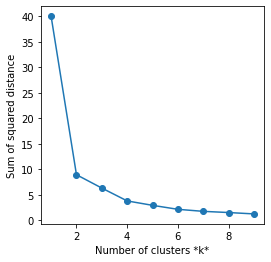

In [0]:
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(Clus_dataSet)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(4, 4))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [0]:
# set number of clusters
kclusters = 2

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Clus_dataSet)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0], dtype=int32)

In [0]:
# add clustering labels
df_work.insert(0, 'Cluster Labels', kmeans.labels_)

In [0]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# generate choropleth map
map_clusters.choropleth(
    geo_data=arrond_geo,
    data=df_work,
    columns=['objectid','Cluster Labels'],
    key_on='feature.properties.objectid',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Paris Cluster'
)

# display map       
map_clusters

/usr/local/lib/python3.6/dist-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [0]:
df_work.groupby('Cluster Labels').mean()

,code_postal,price_m2,objectid,mutation_nbr,Resto_Count,activities_count,population_count
Cluster Labels,,,,,,,
0,75015.0,9296.592505,15.0,1510.636364,60.000000,55.727273,167538.363636
1,75005.0,11572.224527,5.0,582.000000,85.111111,43.666667,38600.555556
